In [1]:
from pprint import pprint
from datetime import datetime
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view
from utils import *
from utils import markdown
from scipy import stats
from collections import defaultdict
from itertools import product


def data_iterator():
    data = load_nested_dict('data/Processed', ignore=IGNORE_NO_EYETRACKING)
    for i, (participant, _data1) in enumerate(data.items()):
        for j, (experiment, _data2) in enumerate(_data1.items()):
            yield (i, participant), (j, experiment[3:]), _data2

def compute_failure_proportion_intervals():
    data = load_nested_dict('data/Processed')
    def _gen():
        for (_, participant), (_, experiment), _data2 in data_iterator():
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            for task, _data3 in sorted(_data2['tasks'].items()):
                failure_intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
                failure_intervals = merge_intervals(failure_intervals) - start_time # merge them to get failures for a single task
                if len(failure_intervals) > 0:
                    yield np.full(failure_intervals.shape[0], participant), np.full(failure_intervals.shape[0], experiment), np.full(failure_intervals.shape[0], task), failure_intervals[:,0], failure_intervals[:,1]
    data = [np.concatenate(x, axis=0) for x in zip(*_gen())]
    data = dict(zip(['participant', 'experiment', 'task', 't1', 't2'], data))
    return pd.DataFrame(data)

def compute_warning_intervals():
    def _compute_warning_intervals(data, task, start_time, finish_time):
        data = data['warnings'][task]
        return compute_time_intervals(data['value'].astype(int), data['timestamp'], start_time, finish_time).intervals
    def _gen():
        for (_, participant), (_, experiment), _data2 in data_iterator():
            if 'icua' in experiment:
                start_time, finish_time =  _data2['start_time'], _data2['finish_time']
                for task, _data3 in sorted(_data2['tasks'].items()):
                    wi = _compute_warning_intervals(_data2, task, start_time, finish_time) - start_time
                    if len(wi) > 0:
                        yield np.full(wi.shape[0], participant), np.full(wi.shape[0], experiment), np.full(wi.shape[0], task), wi[:,0], wi[:,1]
    data = [np.concatenate(x, axis=0) for x in zip(*_gen())]
    data = dict(zip(['participant', 'experiment', 'task', 't1', 't2'], data))
    return pd.DataFrame(data)    
     
def compute_eyetracking_intervals():
    def _compute_eyetracking_intervals(data, task, start_time, finish_time, gaze_only=True):
        data = data['eye_tracking']
        window_properties = ALL_WINDOW_PROPERTIES[task]
        # compute gaze intervals
        intaskbox = in_box(data['x'].to_numpy(), data['y'].to_numpy(), window_properties['position'], window_properties['size'])
        if gaze_only: # USE THIS IF WE ONLY WANT GAZE
            gaze = data['gaze'].to_numpy().astype(bool)
            intaskbox = np.logical_and(intaskbox, gaze).astype(int)
        return compute_time_intervals(intaskbox, data['timestamp'].to_numpy(), start_time, finish_time, pad='next').intervals
    
    def _gen():
        for (_, participant), (_, experiment), _data2 in data_iterator():
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            for task, _data3 in sorted(_data2['tasks'].items()):
                wi = _compute_eyetracking_intervals(_data2, task, start_time, finish_time) - start_time
                yield np.full(wi.shape[0], participant), np.full(wi.shape[0], experiment), np.full(wi.shape[0], task), wi[:,0], wi[:,1]
    
    data = [np.concatenate(x, axis=0) for x in zip(*_gen())]
    data = dict(zip(['participant', 'experiment', 'task', 't1', 't2'], data))
    return pd.DataFrame(data)
            
dfp = compute_failure_proportion_intervals()
dfw = compute_warning_intervals()
dfe = compute_eyetracking_intervals()


In [2]:
# create a dataframe looking at task (1), failure at task (3), warning at (1)

# The data frame is computed using the timestamps of each GAZE event `tstamp`.
def transition_pattern_count(data, n=2):
    from numpy.lib.stride_tricks import sliding_window_view
    tp = sliding_window_view(data, (n,)).squeeze()
    u, c = np.unique(tp, axis=0, return_counts=True)
    columns = [f"t{i}" for i in range(n)] + ["count"]
    return pd.DataFrame(data=np.concatenate([u,c[:,np.newaxis]], axis=1), columns=columns)


dfpg = dfp.groupby(['participant', 'experiment'])
dfwg = {k:v.iterrows() for k,v in dfw.groupby(['participant', 'experiment'])}
result = {}

for (_, participant), (_, experiment), data in data_iterator():
    result[participant] = result.get(participant, {})
    
    start_time, finish_time =  data['start_time'], data['finish_time']
    et = data['eye_tracking']
    et['timestamp'] = et['timestamp'] - start_time
    et['looking at'] = np.full(len(et), 'none') # non-overlapping
    et['warning at'] = np.full(len(et), 'none') # non-overlapping
    
    
    for task, window_properties in ALL_WINDOW_PROPERTIES.items():
        intaskbox = in_box(et['x'].to_numpy(), et['y'].to_numpy(), window_properties['position'], window_properties['size'])
        et.loc[intaskbox, 'looking at'] = task
        et[f"fa-{task}"] = np.zeros(len(et), dtype=int) # failure at
        
    et = et.drop('x', axis=1).drop('y', axis=1)
    et['gaze'] = et['gaze'].astype(int)
    tstamp = et['timestamp'].to_numpy()
    
    for _, row in dfpg.get_group((participant, experiment)).iterrows():
        ininterval = np.logical_and(tstamp > row['t1'], tstamp < row['t2'])
        et.loc[ininterval, f"fa-{row['task']}"] = 1
    
    for _, row in dfwg.get((participant, experiment), []):
        ininterval = np.logical_and(tstamp > row['t1'], tstamp < row['t2'])
        et.loc[ininterval, 'warning at'] = row['task']
        
    result[participant][experiment] = et
    
    
def transition_points(df):
    # gets the first gaze event at each transition between tasks (doesnt include gazes at none).
    tp = df[1:][np.diff(df['gaze']) > 0]#.reset_index(drop=True)
    tp = tp[np.concatenate([[True], np.diff(tp['looking at'].astype('category').cat.codes) != 0])]
    tp = tp[tp['looking at'] != 'none'].reset_index(drop=True)
    return tp

def warning_count(df):
    return (df['warning at'] != 'none').shape[0]
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 120)



icuA


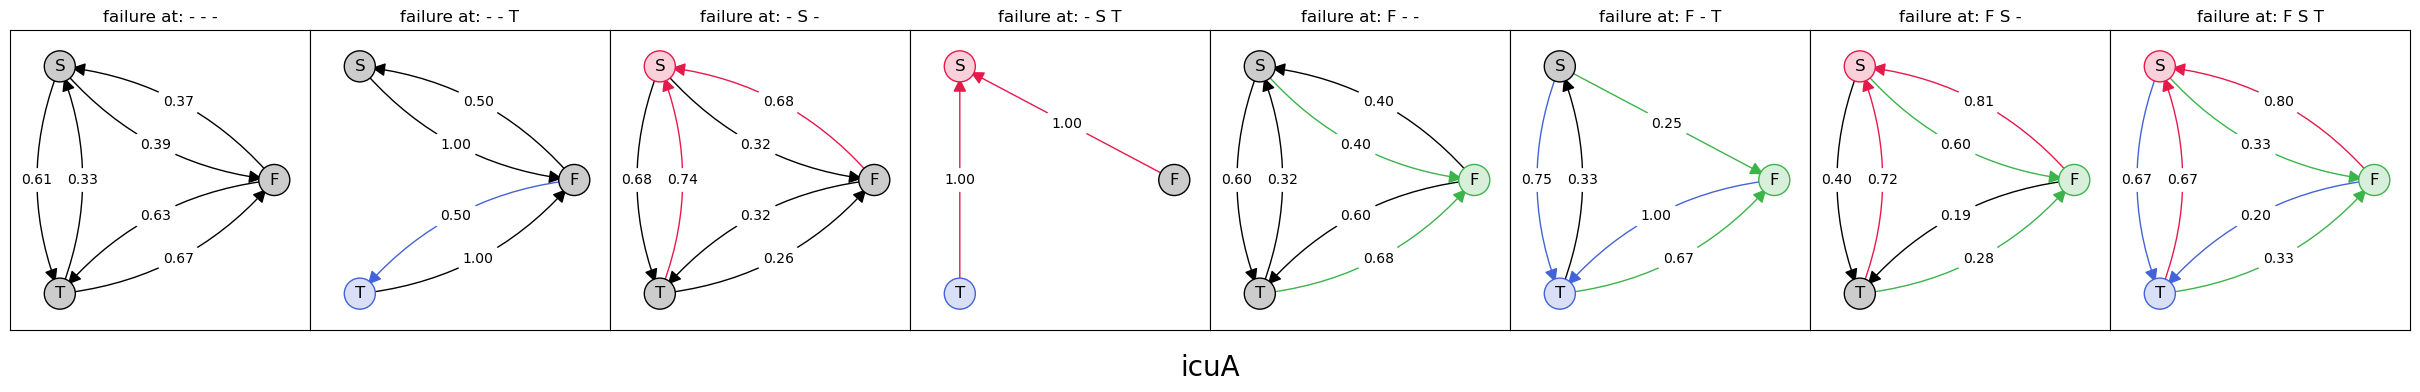

icuaA


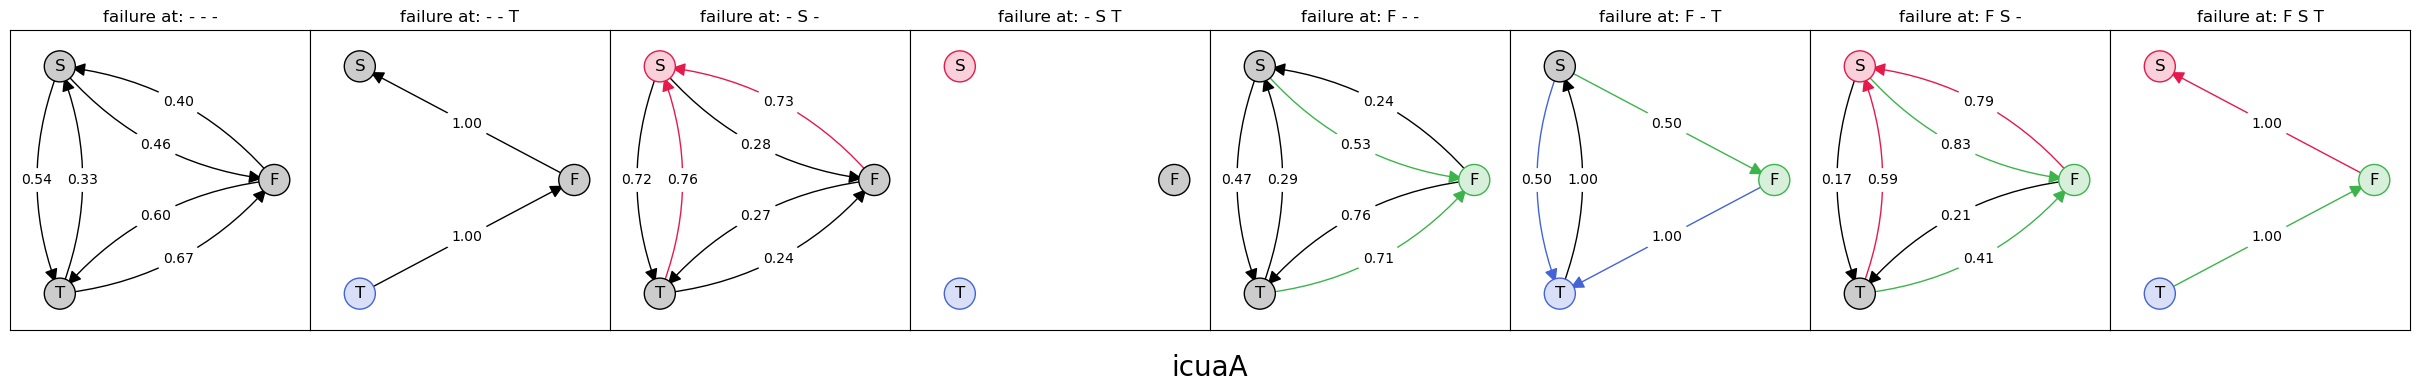

icuB


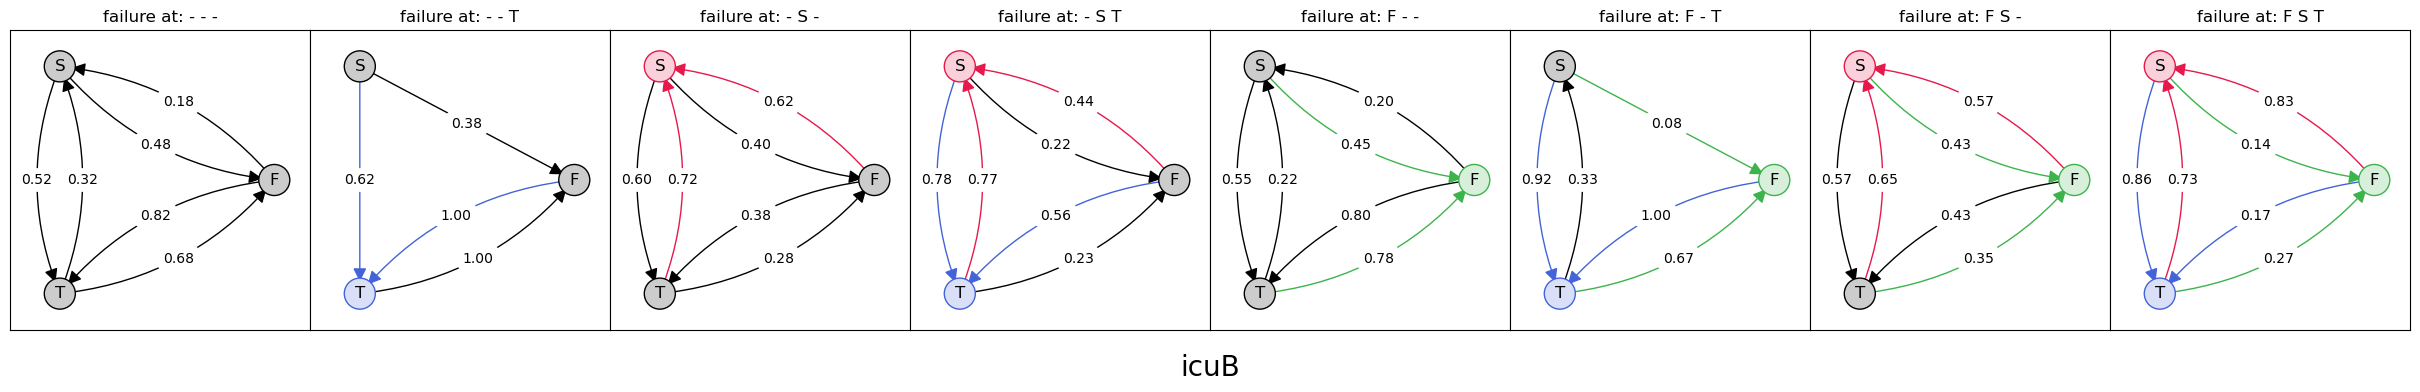

icuaB


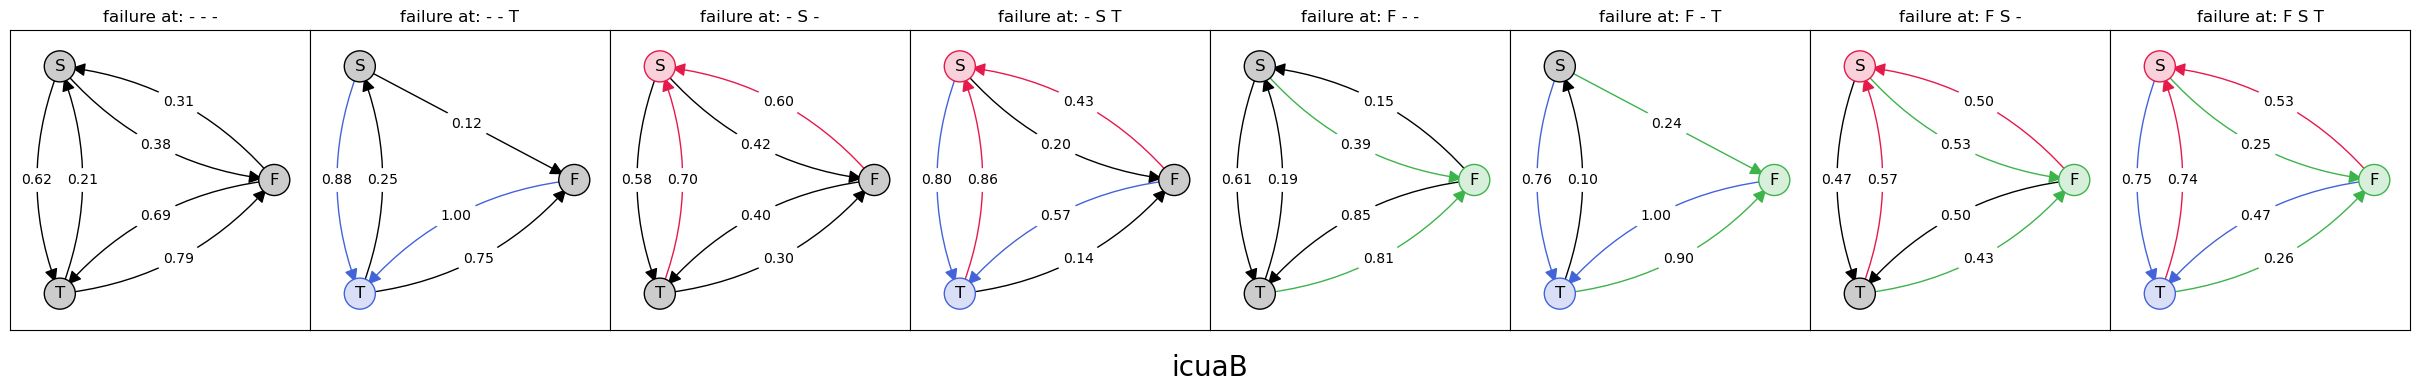

In [16]:

# Converts a data frame (generated by the previous cell) for a single participant/experiment to a transition dataframe.
# A transition dataframe contains an extra column "look at before" which is the task that a particpant looked at 
# prior to the current (looking at).
def to_transition_dataframe(df):
    states = ['fuel', 'system', 'tracking', 'none']
    df = transition_points(df)
    df, l2 = df[1:].reset_index(drop=True), df['looking at'][:-1].reset_index(drop=True)
    df = df.rename(columns={'looking at' : 'looking at'})
    df['looking at before'] = l2
    df = df.replace({x:x[0].capitalize() for x in states})
    return df

# Uses plot_transitions (see above) to plot transition matrices grouped by failure on the three tasks. 
# Ideally, we should see edge arrows pointing TOWARDS the nodes that are in failur (as indicated by 
# the axis title e.g. ( F - - ) meaning failure at the Fuel task.
def plot_failure_transitions(transition_df, tasks = ['F', 'S', 'T'], node_colors=[FUEL_COLOR, SYSTEM_COLOR, TRACKING_COLOR]):
   
    groups = {x:g for x,g in transition_df.groupby(['fa-fuel', 'fa-system', 'fa-tracking'])}
    groups = defaultdict(lambda :  pd.DataFrame(columns=transition_df.columns), groups)
    all_possible_groups = list(product([0,1], repeat=3))
    fig, axes = plt.subplots(nrows=1, ncols=len(all_possible_groups), figsize=(3*len(all_possible_groups),3), sharex=True, sharey=True)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    for ax, possible_group in zip(axes.ravel(), all_possible_groups):
        group = groups[possible_group]
        label = " ".join([('-', task)[i] for task, i in zip(tasks, possible_group)])
        color = [('#000000', color)[i] for color, i in zip(node_colors, possible_group)]
        ax.set_title(f"failure at: {label}")
        plot_transitions(group, ax, node_colors=color) 
    return fig
    
    
# Given a dataframe of transitions (see to_transition_data_frame above) 
# this function will compute and plot the transition matrix as a graph using the networkx package.
def plot_transitions(transition_df, ax, tasks = ['F', 'S', 'T'], counts=False, node_colors=None):
    # this allows for missing columns in the transition_df
    transition_matrix = pd.crosstab(tasks, tasks)
    _transition_matrix = pd.crosstab(transition_df['looking at before'], transition_df['looking at'])
    transition_matrix.update(_transition_matrix)
    transition_matrix = transition_matrix.astype(int)
    transition_matrix.values[np.diag_indices_from(transition_matrix)] = 0 # remove self transitions as they dont draw properly, they are also not important?
    transition_matrix.index.name = None
    transition_matrix.columns.name = None
    if not counts:
        transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
        transition_matrix = transition_matrix.applymap(lambda x: "{:.2f}".format(x))
    return draw_transition_matrix(transition_matrix, ax, node_colors=node_colors)

    
    
# Gather together all participants and show overall transition probabilities.
transition_dfs = defaultdict(list)
for participant, data in result.items():
    experiments = list(sorted(data.keys(), key = lambda x : x[-1]))
    for exp in experiments:
        transition_dfs[exp].append(to_transition_dataframe(data[exp]))

for exp, dfs in transition_dfs.items():
    print(exp)
    df = pd.concat(dfs, ignore_index=True)
    fig = plot_failure_transitions(df)
    fig.suptitle(f"{exp}", y=-0.08,fontsize=20 )
    plt.savefig(f"results/transition_matrices/all-{exp}-transition.png", bbox_inches="tight")
    
    plt.show()
        

In [4]:
 
# Uses plot_transitions (see above), to plot transition matrices grouped by warnings displayed. 
# As warnings can only be displayed on one task at a time, this function differs slightly from 
# plot_failure_transitions, it does not make 
def plot_warning_transitions(transition_df, participant, experiment, tasks = ['F', 'S', 'T']):
    #print(transition_df)
    groups = [(x,g) for x, g in transition_df.groupby('warning at')]
    for T in tasks + ['N']:
        if T not in [z[0] for z in groups]:
            groups.append((T, pd.DataFrame(columns=transition_df.columns)))
    
    fig, axes = plt.subplots(nrows=1, ncols=len(groups), figsize=(3*len(groups),3), sharex=True, sharey=True, squeeze=False)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    
    for ax, (x, g) in zip(axes.ravel(),  sorted(groups, key=(lambda x: (['N'] + tasks).index(x[0])))):
       
        #         x = [('-', task)[i] for task, i in zip(tasks, x)]
        ax.set_title(f"{participant} {experiment} warning at: {x}")
        plot_transitions(g, ax) 
    # plt.savefig(f"results/transition_matrices/{participant}-{exp}-transition.png", bbox_inches="tight")
    plt.show()
    
# for participant, data in result.items():
#     experiments = list(sorted(data.keys(), key = lambda x : x[-1]))
#     for exp in experiments:
#         transition_df = to_transition_dataframe(data[exp])
        
#         print(transition_df)
#         #plot_failure_transitions(transition_df)
# #         if 'a' in exp:
# #             plot_warning_transitions(transition_df, participant, exp)
        
        
    
    
#         #fig.suptitle(participant, )



In [26]:
def good_bad_neutral(df):
    good, bad, neut = [], [], []
    
    result = pd.DataFrame(columns=['looking at', 'failure at fuel', 'failure at system', 'failure at tracking', 'good', 'bad', 'neutral'])
    
    gsum, bsum, nsum = 0, 0, 0
    for x, g in df[1:].groupby(['looking at', 'fa-fuel', 'fa-system', 'fa-tracking']):
        # 'fa-system', 'fa-fuel', 'fa-tracking'
        vc = df['looking at'].iloc[g.index -1].value_counts().reindex(['fuel', 'system', 'tracking'], fill_value=0)
        
        print(vc)
        
        # vs shows the distribution FROM -> x
        # the "good" groups in this are those whose `looking at` matches the failure. This means that the participant moved from the given task to the failed task.
        # since more than one task can fail at once, as long as the participant moves to one of these we say it is "good".
        # note that it may not be optimal to move immediately to the failure, especially if another task 
        # is just about to fail. This might be prevented before moving to the failed task, but we do not consider this here.
        print(x, vc)
        

        #         if sum(x[1:]) == 0: # neutral (no failures)
        #             neut.append((x[0],[*x[1:]],[*vc]))
        #             nsum += vc.sum()
        #         elif ((x[1] == 1) and (x[0] == 'fuel')) or ((x[2] == 1) and (x[0] == 'system')) or ((x[3] == 1) and (x[0] == 'tracking')):
        #             good.append((x[0],[*x[1:]],[*vc]))
        #             gsum += vc.sum()
        #         else:
        #             bad.append((x[0],[*x[1:]],[*vc]))
        #             bsum += vc.sum()
    return good, bad, neut, (gsum, bsum, nsum)

def compute_good_bad_neutral(data, k1, k2):
    s, sa = data[k1], data[k2]
    tp = transition_points(s)
    tpa = transition_points(sa)
    gbn = good_bad_neutral(tp)
    gbna = good_bad_neutral(tpa)
    _tpa = tpa[tpa['warning at'] != 'none']
    return gbn, gbna, _tpa
    
diffs = [] # participants going on to make "good" or "bad" decisions with/without assistance
tps = []  # how much did participants take head of assistance...

for participant, data in result.items():
    print(participant)
    
    gbn, gbna, _tpa = compute_good_bad_neutral(data, 'icuA', 'icuaA')
    da = np.array(gbna[-1]) - np.array(gbn[-1])
    ta = ((_tpa['looking at'] == _tpa['warning at']).sum(), _tpa.shape[0])
    
    # print(_tpa)
    
    # print(f"{participant} {(_tpa['looking at'] == _tpa['warning at']).sum()}/{_tpa.shape[0]} " )
    # print(participant, "A", gbn[-1], gbna[-1], da)
    
    gbn, gbna, _tpa = compute_good_bad_neutral(data, 'icuB', 'icuaB')
    
    db = np.array(gbna[-1]) - np.array(gbn[-1])
    
    print(gbn[0])
    print(gbn[1])
    print(gbn[2])
    
    tb = ((_tpa['looking at'] == _tpa['warning at']).sum(), _tpa.shape[0])
    
    print(participant,f"A: { f'{ta[0]}/{ta[1]}':6} B: {tb[0]}/{tb[1]}")
    
    
    # print(f"{participant} {(_tpa['looking at'] == _tpa['warning at']).sum()}/{_tpa.shape[0]} " )
    # print(participant, "B", gbn[-1], gbna[-1], db)

    diffs.append((da, db))
    tps.append((ta, tb))
    
    break
    
    
# dA, dB = zip(*diffs)
# dA, dB = np.stack(dA)[:,:2], np.stack(dB)[:,:2]
    
    
# tA, tB = zip(*tps)
# tA, tB = np.stack(tA), np.stack(tB)
    

# def per(d):
#     _d = d.copy()
#     _d[:,0] = _d[:,0] > 0 
#     _d[:,1] = _d[:,1] < 0
#     return _d

# _dA = per(dA)
# _dB = per(dB)



# print(np.concatenate([_dA, tA], axis=1))
# print(np.concatenate([_dB, tB], axis=1))



# print(_dA.sum(axis=0), "/", _dA.shape[0])
# print(_dB.sum(axis=0), "/", _dA.shape[0])



P01
fuel         1
system      17
tracking    31
Name: looking at, dtype: int64
('fuel', 0, 0, 0) fuel         1
system      17
tracking    31
Name: looking at, dtype: int64
fuel        0
system      1
tracking    7
Name: looking at, dtype: int64
('fuel', 0, 1, 0) fuel        0
system      1
tracking    7
Name: looking at, dtype: int64
fuel        0
system      1
tracking    0
Name: looking at, dtype: int64
('fuel', 1, 0, 0) fuel        0
system      1
tracking    0
Name: looking at, dtype: int64
fuel        18
system       0
tracking    20
Name: looking at, dtype: int64
('system', 0, 0, 0) fuel        18
system       0
tracking    20
Name: looking at, dtype: int64
fuel        5
system      0
tracking    6
Name: looking at, dtype: int64
('system', 0, 1, 0) fuel        5
system      0
tracking    6
Name: looking at, dtype: int64
fuel        27
system      26
tracking     3
Name: looking at, dtype: int64
('tracking', 0, 0, 0) fuel        27
system      26
tracking     3
Name: looking at,

In [27]:

sorted(['system', 'fuel',  'tracking'])


['fuel', 'system', 'tracking']

In [28]:


sA, saA = df[df['experiment'] == 'icuA'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaA'].sort_values('participant').reset_index(drop=True)
sB, saB = df[df['experiment'] == 'icuB'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaB'].sort_values('participant').reset_index(drop=True)

mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'])
mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'])
print(f"A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
print(f"B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

def plot_hist(data):
    # Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
    _df = pd.DataFrame(data)
    sns.histplot(data=_df, kde=True, alpha=0.6, palette='pastel', bins=100)
    plt.legend(data.keys())
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Comparison of Histograms')
    plt.show()
    
plot_hist({'sA': sA['score'], 'saA': saA['score']})
plot_hist({'sB': sB['score'], 'saB': saB['score']})



KeyError: 'experiment'

In [ ]:
#_fe = fe[fe['task'] == row['task']] # efficiency (not required)
#_fe1 = (_fe['t1'] > row['t1']) & (_fe['t1'] < row['t2']) # gaze started during failure
#_fe2 = (_fe['t2'] > row['t1']) & (_fe['t2'] < row['t2']) # gaze ended during failure
#_fe3 = (_fe['t1'] < row['t1']) & (_fe['t2'] > row['t2']) # gaze across failure
#_fe = _fe[_fe1 | _fe2 | _fe3] # check for gaze within the interval
# also check time from start/end of failure interval
#t1 = np.array([*_fe['t1'].to_numpy(), row['t2']])
#t2 = np.array([row['t1'], *_fe['t2'].to_numpy()])

#print(t1, t2)

#yield np.any((t1 - t2) > GRACE_PERIOD) # this means a highlight would have been shown!



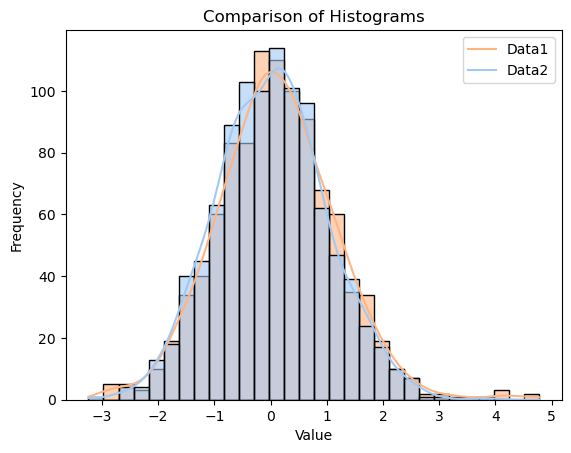

MannwhitneyuResult(statistic=478242.0, pvalue=0.09200641377610866)


In [199]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generating two sets of random data for comparison
np.random.seed(42)
data1 = np.random.normal(loc=0, scale=1, size=1000)
a = 0.99
data2 = np.concatenate([np.random.normal(loc=0, scale=1, size=int(1000*a)), np.random.normal(loc=3, scale=1.5, size=int(1000*(1-a)))])



# Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
df = pd.DataFrame({'Data1': data1, 'Data2': data2})

# Plot the histograms using Seaborn
sns.histplot(data=df, kde=True, bins=30, alpha=0.6, palette='pastel')

# Add a legend to distinguish the two datasets
plt.legend(['Data1', 'Data2'])

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Comparison of Histograms')

# Show the plot
plt.show()

print(stats.mannwhitneyu(data1, data2))


In [206]:
import numpy as np

def intervals_overlapping_intervals(A, B):
    result = np.zeros((len(A), len(B)), dtype=bool)
    # Check for each interval in A if it overlaps with any interval in B
    for i in range(len(A)):
        result[i] = (A[i, 0] <= B[:, 1]) & (A[i, 1] >= B[:, 0])
    return result

# Example usage
if __name__ == "__main__":
    A = [(1, 4)]
    B = [(-1,0),(0,2),(2,3),(3,5),(5,6)]

    result = intervals_overlapping_intervals(A, B)
    print("Intervals overlapping with B:")
    print(result)

    

Intervals overlapping with B:
[[False  True  True  True False]]


P01 & 0.105 & 0.109 \\ \hline 


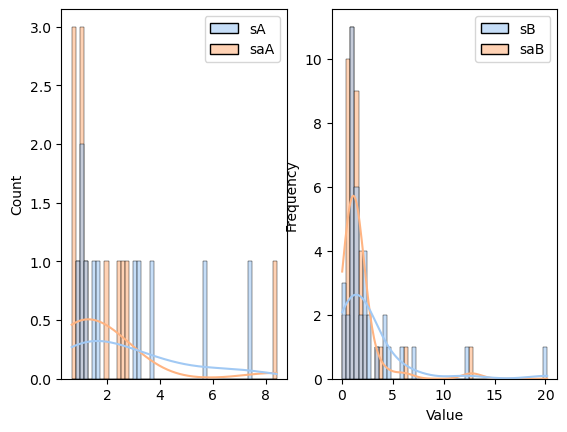

P02 & 0.804 & 0.789 \\ \hline 


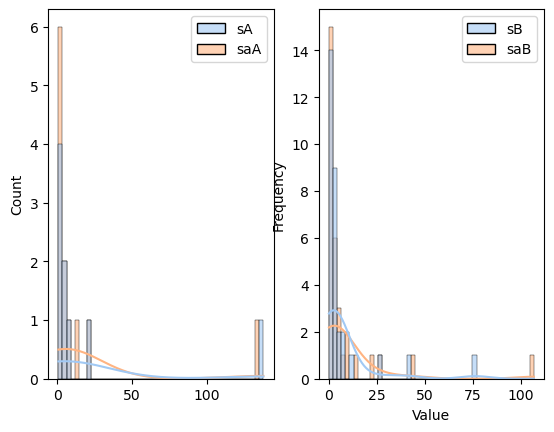

P04 & 0.482 & 0.455 \\ \hline 


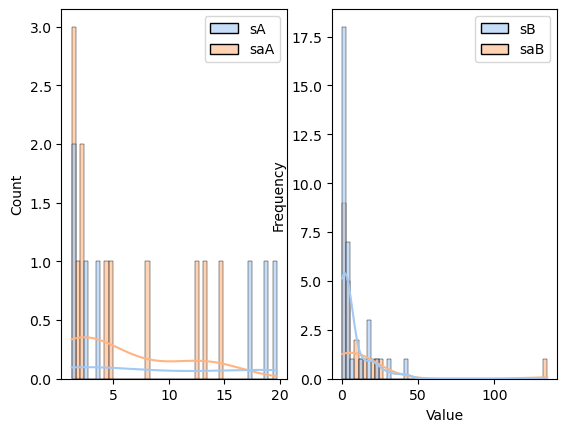

P05 & 0.865 & 0.747 \\ \hline 


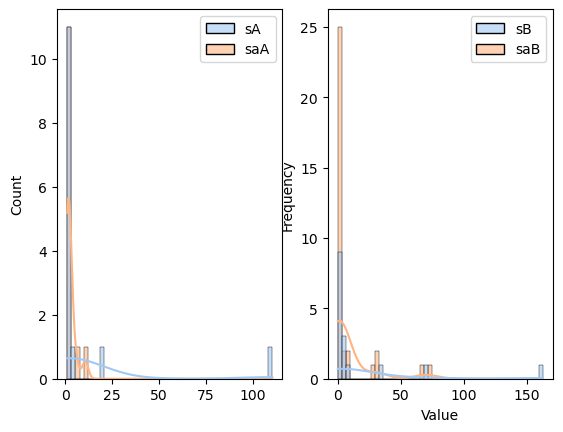

P06 & 0.074 & 0.887 \\ \hline 


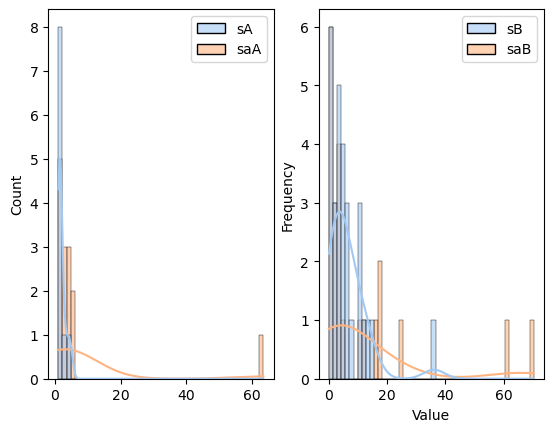

P07 & 0.465 & 0.099 \\ \hline 


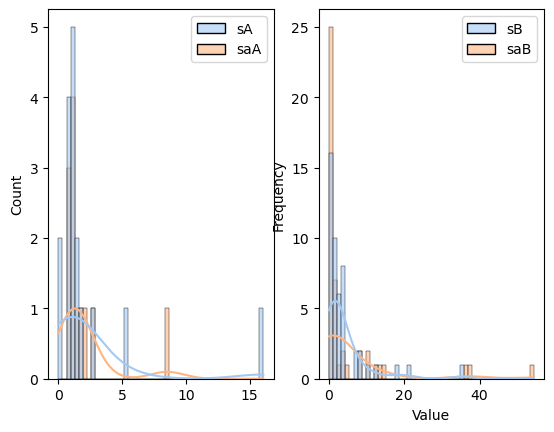

P08 & 0.633 & 0.902 \\ \hline 


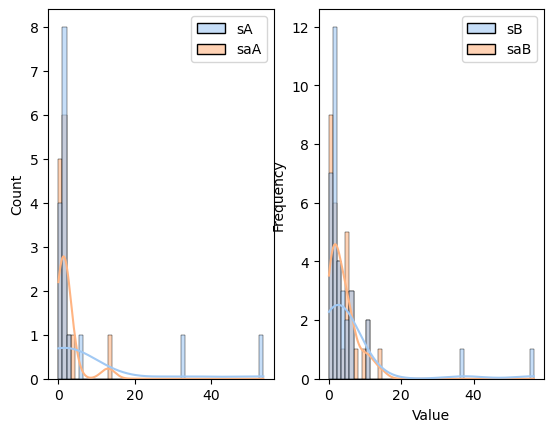

P09 & 0.003 & 0.412 \\ \hline 


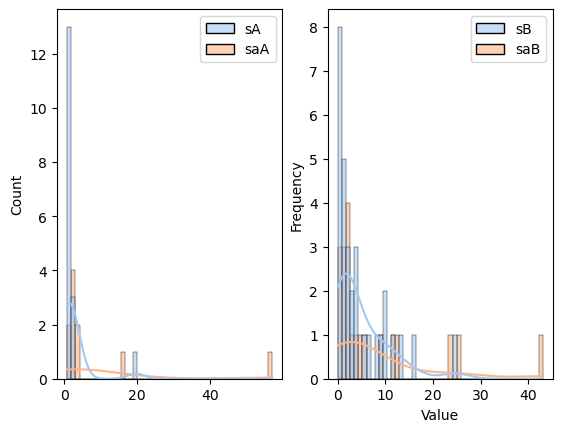

P10 & 0.229 & 0.245 \\ \hline 


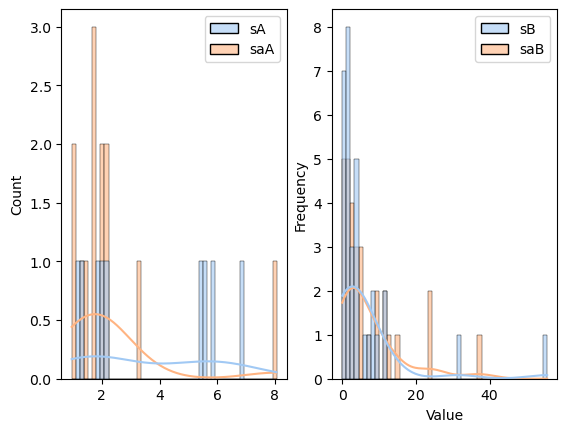

P16 & 0.972 & 0.135 \\ \hline 


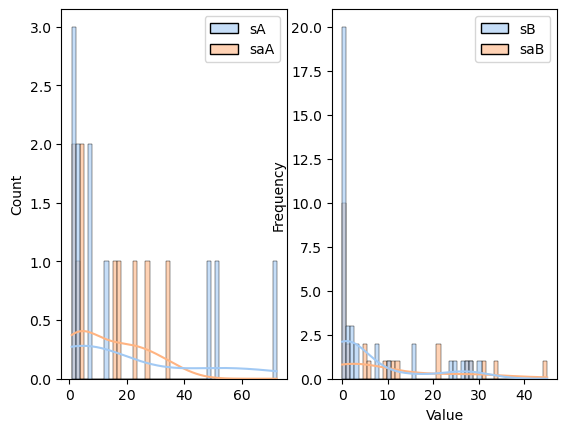

P17 & 0.501 & 0.168 \\ \hline 


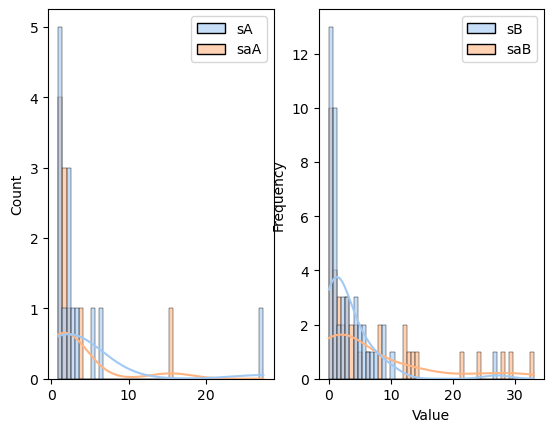

P18 & 0.281 & 0.981 \\ \hline 


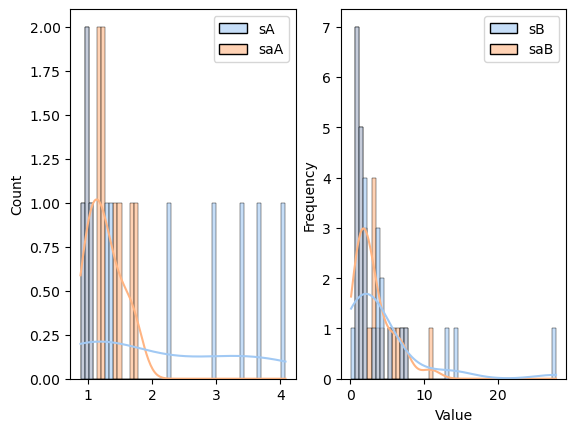

P23 & 0.189 & 0.778 \\ \hline 


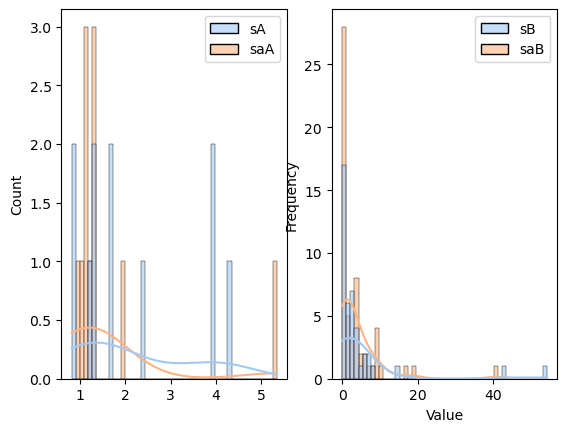

P24 & 0.384 & 0.009 \\ \hline 


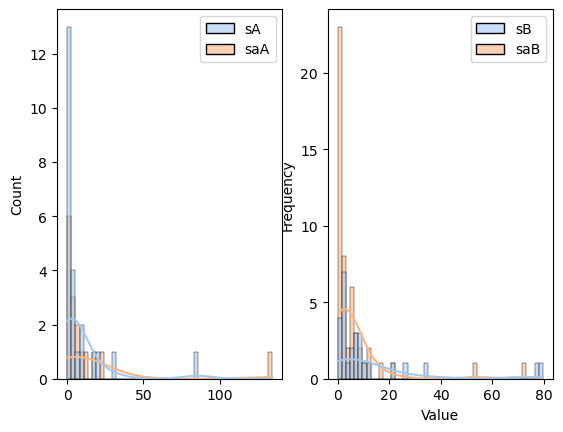

P25 & 0.165 & 0.759 \\ \hline 


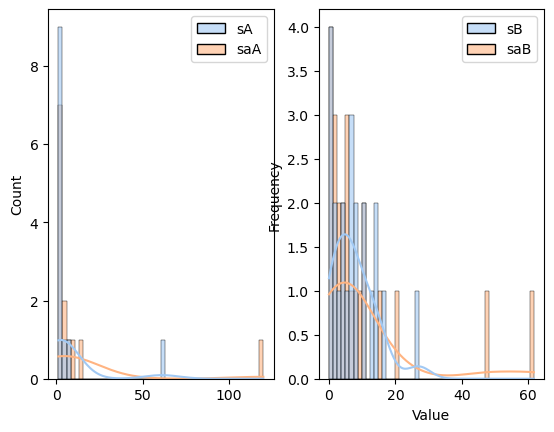

In [69]:
# group by participant
fp = compute_failure_proportion_intervals()
fp['score'] = fp['t2'] - fp['t1']

def plot_hist(data, ax):
    # Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
    _df = pd.DataFrame(data)
    sns.histplot(data=_df, ax=ax, kde=True, alpha=0.6, palette='pastel', bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

for p, df in fp.groupby('participant'):
    
    sA, saA = df[df['experiment'] == 'icuA'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaA'].sort_values('participant').reset_index(drop=True)
    sB, saB = df[df['experiment'] == 'icuB'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaB'].sort_values('participant').reset_index(drop=True)

    mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'])
    mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'])
    #print(f"{p} A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
    #print(f"{p} B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")
    print(f"{p} & {mannwhitneyuA.pvalue:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes = axes.ravel()
    plot_hist({'sA': sA['score'], 'saA': saA['score']}, axes[0])
    plot_hist({'sB': sB['score'], 'saB': saB['score']}, axes[1])
    plt.show()





fuel & 0.835 & 0.492 \\ \hline 


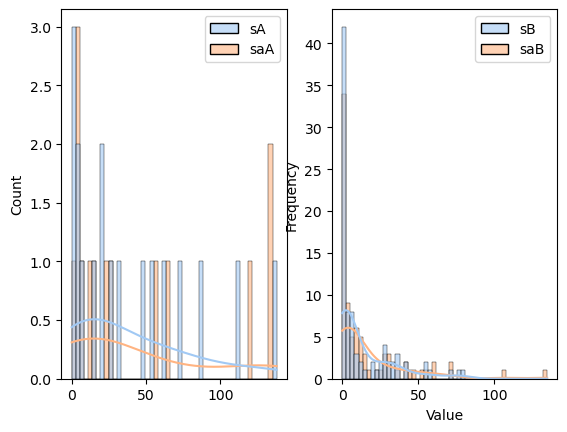

system & 0.289 & 0.477 \\ \hline 


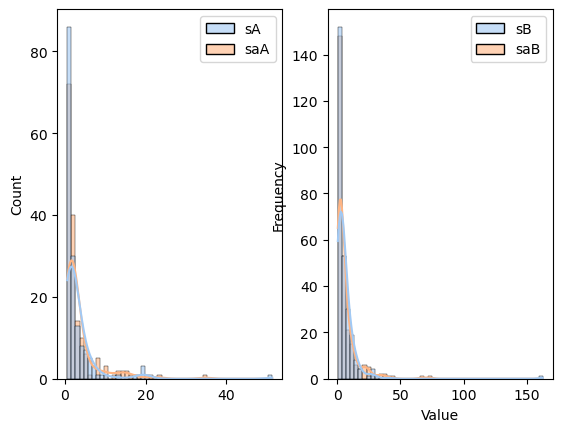

tracking & 0.860 & 0.240 \\ \hline 


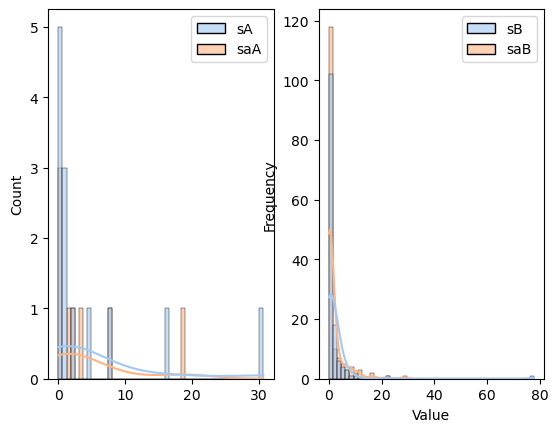

In [75]:
# group by participant
fp = compute_failure_proportion_intervals()
fp['score'] = fp['t2'] - fp['t1']

def plot_hist(data, ax):
    # Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
    _df = pd.DataFrame(data)
    sns.histplot(data=_df, ax=ax, kde=True, alpha=0.6, palette='pastel', bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

for t, df in fp.groupby('task'):
    
    sA, saA = df[df['experiment'] == 'icuA'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaA'].sort_values('participant').reset_index(drop=True)
    sB, saB = df[df['experiment'] == 'icuB'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaB'].sort_values('participant').reset_index(drop=True)

    mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'])
    mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'])
    #print(f"{p} A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
    #print(f"{p} B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")
    print(f"{t} & {mannwhitneyuA.pvalue:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes = axes.ravel()
    plot_hist({'sA': sA['score'], 'saA': saA['score']}, axes[0])
    plot_hist({'sB': sB['score'], 'saB': saB['score']}, axes[1])
    plt.show()





A: 16701.000 & 0.278 \\ \hline 
B: 128781.000 & 0.620 \\ \hline 


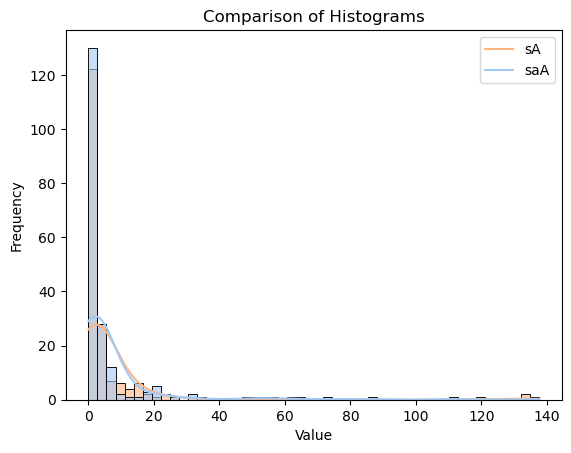

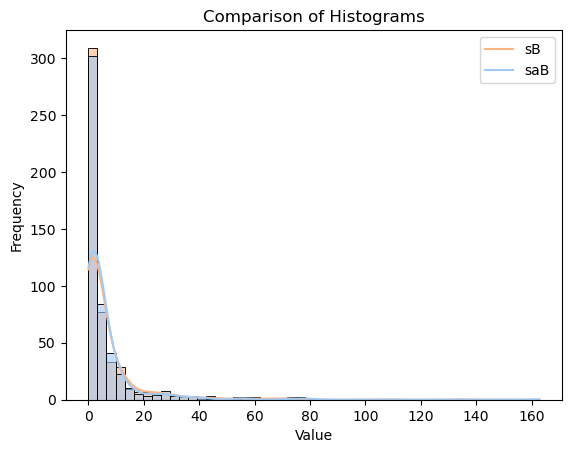

In [73]:
fp = compute_failure_proportion_intervals()
fp['score'] = fp['t2'] - fp['t1']
df = fp

sA, saA = df[df['experiment'] == 'icuA'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaA'].sort_values('participant').reset_index(drop=True)
sB, saB = df[df['experiment'] == 'icuB'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaB'].sort_values('participant').reset_index(drop=True)

mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'])
mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'])
print(f"A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
print(f"B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

def plot_hist(data):
    # Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
    _df = pd.DataFrame(data)
    sns.histplot(data=_df, kde=True, alpha=0.6, palette='pastel', bins=50)
    plt.legend(data.keys())
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Comparison of Histograms')
    plt.show()
    
plot_hist({'sA': sA['score'], 'saA': saA['score']})
plot_hist({'sB': sB['score'], 'saB': saB['score']})


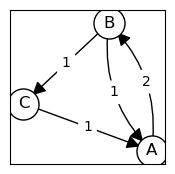

In [5]:
# plotting transition matrix example

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Sample DataFrame
data = {'from_state': ['A', 'B', 'A', 'B', 'C'],
        'to_state':   ['B', 'A', 'B', 'C', 'A']}
df = pd.DataFrame(data)

# Create a transition matrix using crosstab
transition_matrix = pd.crosstab(df['from_state'], df['to_state'])

# Draw the graph
plt.figure(figsize=(2,2))

draw_transition_matrix(transition_matrix, plt.gca())